# **Final Project: Spotify Music Recommendation System**

### Team Members:
### placeholder


### Package Installation

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
!pip3 install spotipy

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

### Data Import

In [77]:
data = pd.read_csv("/content/drive/My Drive/spotify-dataset/data/data.csv")
songs_data = pd.read_csv('/content/drive/My Drive/spotify-dataset/data/data.csv')
genre_data = pd.read_csv('/content/drive/My Drive/spotify-dataset/data/data_by_genres.csv')

In [78]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()),
                                  ('kmeans', KMeans(n_clusters=20,
                                   verbose=False))
                                 ], verbose=False)

X = data.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

### Connect to Spotify API

In [79]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_id = "7d79fe83da984659b5581054295c34c9"
client_secret = "432302ce5805441dac55670e8a6144bd"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [80]:
# API testing
name = ["Michael Jackson","pitbull","Christina","Elvis Presley"]
result = sp.search(name)
result['tracks']['items'][1]['artists']

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3fMbdgg4jU18AjLCKBhRSm'},
  'href': 'https://api.spotify.com/v1/artists/3fMbdgg4jU18AjLCKBhRSm',
  'id': '3fMbdgg4jU18AjLCKBhRSm',
  'name': 'Michael Jackson',
  'type': 'artist',
  'uri': 'spotify:artist:3fMbdgg4jU18AjLCKBhRSm'}]

## K-means clustering on songs

In [84]:
# Reload data in seperate data frame
songs_df = pd.read_csv('/content/drive/My Drive/spotify-dataset/data/data.csv')

selected_features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                     'liveness', 'loudness', 'speechiness', 'valence', 'tempo',
                     'duration_ms', 'key', 'mode']

### PCA for Dimensionality Reduction (retain 95% variance)

In [85]:
# Standardize the Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(songs_df[selected_features])

pca = PCA(n_components=0.95, random_state=42) # 95%
pca_features = pca.fit_transform(scaled_features)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Number of components selected: {pca.n_components_}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Number of components selected: 10
Explained variance ratio: [0.25730985 0.12498319 0.09818916 0.09240748 0.08111295 0.07534458
 0.07188715 0.06907634 0.05765154 0.03206347]


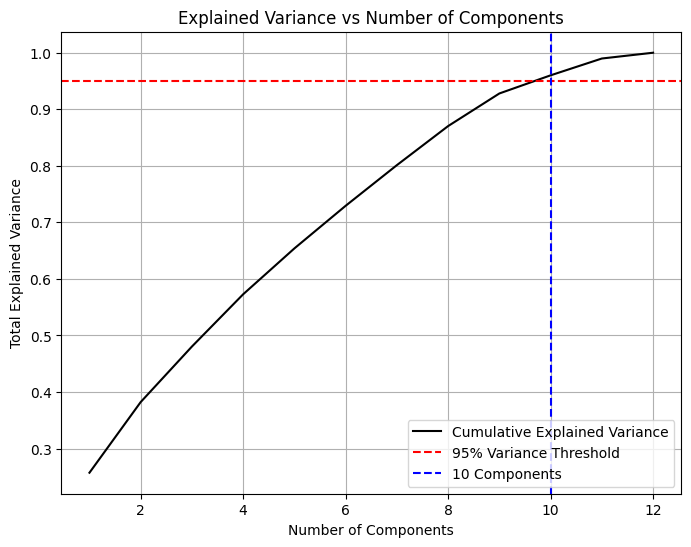

In [86]:
# Calculate Cumulative Variance for Full Components
pca_full = PCA(random_state=42)
pca_full.fit(scaled_features)
explained_variance_full = pca_full.explained_variance_ratio_
cumulative_variance_full = np.cumsum(explained_variance_full)

# Plot total explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_full) + 1), cumulative_variance_full, color='black', label="Cumulative Explained Variance")
plt.axhline(y=0.95, color='red', linestyle='--', label="95% Variance Threshold")
plt.axvline(x=pca.n_components_, color='blue', linestyle='--', label=f"{pca.n_components_} Components")

plt.xlabel('Number of Components')
plt.ylabel('Total Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# plt.figure(figsize=(10, 7))
# plt.plot(cumulative_variance, color='k', lw=2)
# plt.xlabel('Number of components')
# plt.ylabel('Total explained variance')
# plt.xlim(0, len(selected_features))
# plt.yticks(np.arange(0, 1.1, 0.1))
# plt.axvline(pca.n_components_, c='b', label=f'{pca.n_components_} components')
# plt.axhline(0.95, c='r', label='95% variance')
# plt.legend()
# plt.show()

In [87]:
# Principal Component Loadings - detailed weighted features for each PC
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'Principal Component {i+1}' for i in range(pca.n_components_)],
    index=selected_features
)

print("Feature Contributions to Principal Components:")
print(loadings)

Feature Contributions to Principal Components:
                  Principal Component 1  Principal Component 2  \
acousticness                  -0.440481               0.215932   
danceability                   0.306516               0.508978   
energy                         0.490527              -0.263143   
instrumentalness              -0.313767              -0.123150   
liveness                       0.042022              -0.115393   
loudness                       0.473749              -0.203820   
speechiness                    0.025323               0.430630   
valence                        0.325461               0.390311   
tempo                          0.193530              -0.134148   
duration_ms                   -0.039905              -0.444167   
key                            0.026775               0.044407   
mode                          -0.020607              -0.003063   

                  Principal Component 3  Principal Component 4  \
acousticness                

In [88]:
# PC and explained variance display
components_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance,
    'Cumulative Variance': cumulative_variance
})

print("\nExplained Variance for Principal Components:")
print(components_df)


Explained Variance for Principal Components:
  Principal Component  Explained Variance  Cumulative Variance
0                 PC1            0.257310             0.257310
1                 PC2            0.124983             0.382293
2                 PC3            0.098189             0.480482
3                 PC4            0.092407             0.572890
4                 PC5            0.081113             0.654003
5                 PC6            0.075345             0.729347
6                 PC7            0.071887             0.801234
7                 PC8            0.069076             0.870311
8                 PC9            0.057652             0.927962
9                PC10            0.032063             0.960026


### Elbow Method to determine optimal k for clustering

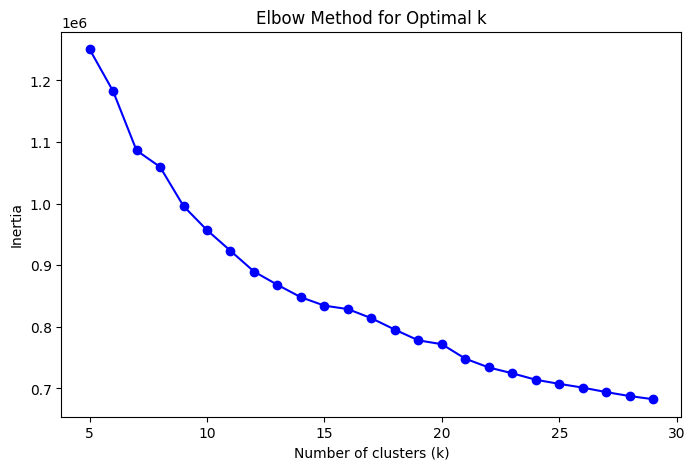

In [89]:
inertias = []
k_values = range(5, 30)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

### Apply K-means Clustering

In [90]:
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(pca_features)

# Assign clusters to the original DataFrame
songs_df['cluster'] = kmeans.labels_

In [91]:
# Function to retrieve song data from Spotify API
def find_song_from_spotify(name, year):
    song_data = defaultdict()
    results = sp.search(q=f'track:{name} year:{year}', limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    # Basic metadata
    song_data['name'] = results['name']
    song_data['artists'] = ', '.join([artist['name'] for artist in results['artists']])
    song_data['year'] = year
    song_data['duration_ms'] = results['duration_ms']
    song_data['explicit'] = int(results['explicit'])

    # Audio features
    for key, value in audio_features.items():
        if key in selected_features:
            song_data[key] = value

    return song_data

In [112]:
def recommend_songs_kmeans_with_api(song_names, songs_df, pca_model, scaler, kmeans_model, n_recommendations=10):
    # Ensure 'cluster' column exists
    if 'cluster' not in songs_df.columns:
        raise KeyError("'cluster' column not found in songs_df. Ensure k-means clustering is performed.")

    clusters = []
    input_song_names = []
    new_songs = []  # Store newly added songs for dynamic clustering

    for song_name, year in song_names:
        matched_songs = songs_df[songs_df['name'].str.lower() == song_name.lower()]
        if matched_songs.empty:
            print(f"Song '{song_name}' not found in the dataset. Fetching from Spotify...")
            # Attempt to fetch song from Spotify API
            spotify_song_data = find_song_from_spotify(song_name, year)
            if spotify_song_data:
                new_songs.append(spotify_song_data)
                print(f"Added '{spotify_song_data['name']}' from Spotify.")
            else:
                print(f"Could not find '{song_name}' on Spotify.")
            continue

        input_song_names.append(song_name.lower())
        song_clusters = matched_songs['cluster'].unique()
        clusters.extend(song_clusters)

    # Dynamically cluster new songs (if any)
    if new_songs:
        new_songs_df = pd.DataFrame(new_songs)
        scaled_new_features = scaler.transform(new_songs_df[selected_features])
        pca_new_features = pca_model.transform(scaled_new_features)
        new_clusters = kmeans_model.predict(pca_new_features)
        new_songs_df['cluster'] = new_clusters
        songs_df = pd.concat([songs_df, new_songs_df], ignore_index=True)
        clusters.extend(new_clusters)

    if not clusters:
        print("No matching songs found in the dataset or Spotify.")
        return []

    # Unique clusters
    clusters = list(set(clusters))

    # Songs in the same cluster(s)
    recommended_songs = songs_df[songs_df['cluster'].isin(clusters)]

    # Exclude input songs
    recommended_songs = recommended_songs[~recommended_songs['name'].str.lower().isin(input_song_names)]

    # Randomly select recommendations
    recommended_songs = recommended_songs.sample(n=n_recommendations, random_state=42)
    return recommended_songs[['name', 'year', 'artists', 'cluster']]

In [113]:
# Test input
input_songs = [{'name': 'Come As You Are', 'year':1991},
                {'name': 'Smells Like Teen Spirit', 'year': 1991},
                {'name': 'Lithium', 'year': 1992},
                {'name': 'All Apologies', 'year': 1993},
                {'name': 'Stay Away', 'year': 1993}]

recommendations = recommend_songs_kmeans_with_api(
    input_songs,
    songs_df,
    pca_model=pca,
    scaler=scaler,
    kmeans_model=kmeans,
    n_recommendations=10
)

# Display recommendations
print(recommendations)

                          name  year  \
149854        Living Testimony  1991   
12661                    Conga  1985   
18269        How Country Feels  2013   
90776            Volví a Nacer  2013   
56847                   Casper  2018   
34437            Brand New Key  1999   
153866  Taking Pictures Of You  2011   
52556              Nour El Ein  1996   
63534       She Don't Love You  1962   
65091        I Gotta Get Drunk  1970   

                                          artists  cluster  
149854             ['Doug Williams', 'Joe Ligon']        1  
12661   ['Gloria Estefan', 'Miami Sound Machine']        1  
18269                            ['Randy Houser']        1  
90776                            ['Carlos Vives']        1  
56847                                 ['Takeoff']        1  
34437                                 ['Melanie']        1  
153866                              ['The Kooks']        1  
52556                                ['Amr Diab']        1  
63534     

## Enhanced K-Means Model with Weighted Genre

In [94]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.spatial.distance import cdist
from collections import defaultdict

In [95]:
# Define feature columns
number_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness',
               'liveness', 'loudness', 'speechiness', 'valence', 'tempo',
               'duration_ms', 'key', 'mode']

In [96]:
def classify_songs_by_genre(songs_df, genre_df, feature_columns):
    """
    Assign each song in the songs_df to the closest genre based on shared features in genre_df.
    """
    # Ensure all features are numeric and explicitly cast to float64
    songs_df[feature_columns] = songs_df[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(songs_df[feature_columns].mean())
    genre_df[feature_columns] = genre_df[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(genre_df[feature_columns].mean())

    # Extract genre features and explicitly cast to float64
    genre_features = genre_df[feature_columns].values.astype(np.float64)
    classified_genres = []

    for _, song in songs_df.iterrows():
        # Extract features for the current song and explicitly cast to float64
        song_features = song[feature_columns].values.reshape(1, -1).astype(np.float64)

        # Compute distances between the song and all genres
        distances = cdist(song_features, genre_features, metric='euclidean')

        # Assign the closest genre
        closest_genre_index = distances.argmin()
        closest_genre = genre_df.iloc[closest_genre_index]['genres']
        classified_genres.append(closest_genre)

    # Add the classified genres to the songs DataFrame
    songs_df['classified_genre'] = classified_genres
    return songs_df

In [98]:
# Classify songs into different genres
songs_with_genre_df = classify_songs_by_genre(songs_data, genre_data, number_cols)

In [102]:
songs_with_genre_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,classified_genre
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,hungarian folk
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,black punk
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,modern big band
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,italian mezzo-soprano
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,vintage swedish pop


In [107]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode the 'classified_genre' column into numeric values
label_encoder = LabelEncoder()
songs_with_genre_df['classified_genre_encoded'] = label_encoder.fit_transform(songs_with_genre_df['classified_genre'])

# Update the feature list
selected_features_with_genre = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                                'liveness', 'loudness', 'speechiness', 'valence', 'tempo',
                                'duration_ms', 'key', 'mode', 'classified_genre_encoded'] # use encoded classfied_genre(convert string to float)

# Standardize the Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(songs_with_genre_df[selected_features_with_genre])

# Apply PCA
pca_genre = PCA(n_components=0.95, random_state=42)  # 95% variance threshold
pca_features_with_genre = pca_genre.fit_transform(scaled_features)

# Calculate Explained Variance
explained_variance_genre_enhanced = pca_genre.explained_variance_ratio_
cumulative_variance_genre_enhanced = np.cumsum(explained_variance_genre_enhanced)

print(f"Number of components selected: {pca_genre.n_components_}")
print(f"Explained variance ratio: {pca_genre.explained_variance_ratio_}")

Number of components selected: 11
Explained variance ratio: [0.23751943 0.11537844 0.09064819 0.08530589 0.07720391 0.07484996
 0.06944568 0.06635613 0.06359495 0.05320371 0.02959504]


In [108]:
# apply k-means clustering
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(pca_features_with_genre)

# Assign clusters to the original DataFrame
songs_with_genre_df['cluster'] = kmeans.labels_

In [114]:
# Test input
input_songs = [{'name': 'Come As You Are', 'year':1991},
                {'name': 'Smells Like Teen Spirit', 'year': 1991},
                {'name': 'Lithium', 'year': 1992},
                {'name': 'All Apologies', 'year': 1993},
                {'name': 'Stay Away', 'year': 1993}]

recommendations = recommend_songs_kmeans_with_api(
    input_songs,
    songs_with_genre_df,
    pca_model=pca_genre,
    scaler=scaler,
    kmeans_model=kmeans,
    n_recommendations=10
)

# Display recommendations
print(recommendations)

                                                name  year  \
145878  I've Got so Much Trouble in My Mind (7" Mix)  1971   
52697                                        Rickets  1997   
55581                                 Hit The Lights  2011   
102505                           Hoochie Coochie Man  1989   
169834                 Growing Up (feat. Ed Sheeran)  2016   
107112                                       Demente  2012   
119324                     Did You Ever Look so Nice  1992   
88920                          Calm Before the Storm  2003   
127211                        Sarvangi Sowas Pari Tu  1952   
53063                                      Privilege  1999   

                                           artists  cluster  
145878          ['Sir Joe Quarterman & Free Soul']        1  
52697                                 ['Deftones']        1  
55581                 ['Selena Gomez & The Scene']        1  
102505                    ['The Jeff Healey Band']        1  
169834 

## Weighted Vector Model with Cosine Similarity - Not yet complete

In [ ]:
def add_genre_vector(songs_df):
    """
    Add one-hot encoded genre vectors to the songs dataset.
    """
    # One-hot encode the genres
    genre_encoder = OneHotEncoder(sparse_output=False)
    genre_encoded = genre_encoder.fit_transform(songs_df[['classified_genre']])
    songs_df['genre_vector'] = list(genre_encoded)
    return songs_df, genre_encoder

# Add genre vectors
songs_df, genre_encoder = add_genre_vector(songs_df)

In [ ]:
# Define feature weights
feature_weights = {
    'valence': 1.0,
    'year': 0.5,
    'acousticness': 1.0,
    'danceability': 1.5,
    'duration_ms': 0.5,
    'energy': 2.0,
    'explicit': 0.1,
    'instrumentalness': 1.0,
    'key': 0.2,
    'liveness': 1.0,
    'loudness': 1.5,
    'mode': 0.5,
    'popularity': 1.0,
    'speechiness': 1.0,
    'tempo': 1.5,
    'genre': 1.0  # Weight for genre vector
}

def get_song_vector_with_weights(song, spotify_data, feature_weights):
    """
    Retrieve the combined song vector (features + genre) with applied weights.
    If the song is not found in the dataset, fetch it from Spotify API.
    """
    try:
        # Try to retrieve the song from the dataset
        song_data = spotify_data[(spotify_data['name'].str.lower() == song['name'].lower()) &
                                 (spotify_data['year'] == song['year'])].iloc[0]
    except IndexError:
        # Song not found in dataset, fetch from Spotify API
        print(f"Fetching '{song['name']}' from Spotify API...")
        song_data = find_song_from_spotify(song['name'], song['year'])
        if song_data is None:
            print(f"Could not find '{song['name']}' on Spotify.")
            return None

    # Combine numerical features and genre vector
    feature_vector = song_data[number_cols].values if isinstance(song_data, pd.Series) else song_data[number_cols].to_numpy()
    genre_vector = np.zeros(len(spotify_data['genre_vector'].iloc[0]))  # Default no genre vector if fetched from API
    if 'genre_vector' in song_data and isinstance(song_data['genre_vector'], np.ndarray):
        genre_vector = np.array(song_data['genre_vector'])

    combined_vector = np.concatenate([feature_vector, genre_vector])

    # Apply weights to the vector
    weighted_features = np.array([feature_vector[i] * feature_weights[col] for i, col in enumerate(number_cols)])
    weighted_genre = genre_vector * feature_weights['genre']
    return np.concatenate([weighted_features, weighted_genre])

In [ ]:
def get_weighted_average_vector(song_list, spotify_data, feature_weights):
    """
    Compute a weighted average vector for the input songs, including genre influence.
    """
    vectors = []
    weights = []

    for song in song_list:
        try:
            # Try to retrieve the combined song vector
            song_vector = get_song_vector_with_weights(song, spotify_data, feature_weights)
            if song_vector is not None:
                vectors.append(song_vector)
                weights.append(1.0)  # Adjust weights dynamically if needed
        except Exception as e:
            print(f"Warning: Could not process '{song['name']}' due to {e}. Skipping...")
            continue

    if len(vectors) == 0:
        raise ValueError("No valid song vectors found.")

    vectors = np.vstack(vectors)
    weights = np.array(weights).reshape(-1, 1)
    return np.average(vectors, axis=0, weights=weights.flatten())

In [ ]:
def recommend_songs_with_genre(song_list, spotify_data, n_songs=10):
    """
    Recommend songs based on weighted vectors and genre influence.
    """
    metadata_cols = ['name', 'year', 'artists', 'classified_genre']

    # Step 1: Compute the weighted average vector for the input songs
    song_center = get_weighted_average_vector(song_list, spotify_data, feature_weights)

    # Step 2: Scale only the numerical features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(spotify_data[number_cols])  # Scale numerical features
    scaled_song_center = scaler.transform([song_center[:len(number_cols)]])  # Scale only the numerical part of the input vector

    # Step 3: Combine scaled numerical features with genre vectors
    genre_vectors = np.array(list(spotify_data['genre_vector']))
    combined_data = np.hstack([scaled_data, genre_vectors])  # Combine scaled numerical and genre vectors
    combined_song_center = np.hstack([scaled_song_center[0], song_center[len(number_cols):]])  # Combine input features

    # Step 4: Compute distances and find nearest songs
    distances = cdist([combined_song_center], combined_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])

    # Exclude input songs from recommendations
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin([song['name'] for song in song_list])]
    return rec_songs[metadata_cols].to_dict(orient='records')


In [ ]:
# Test input songs
input_songs = [{'name': 'Come As You Are', 'year':1991},
                {'name': 'Smells Like Teen Spirit', 'year': 1991},
                {'name': 'Lithium', 'year': 1992},
                {'name': 'All Apologies', 'year': 1993},
                {'name': 'Stay Away', 'year': 1993}
               ]

# Get recommendations
recommendations = recommend_songs_with_genre(input_songs, songs_df, n_songs=10)

# Convert recommendations to a DataFrame
recommendations_df = pd.DataFrame(recommendations)

# Display the DataFrame
print(recommendations_df)